# Wikidata Image Download with Original Sizes

This notebook downloads images from Wikidata while preserving their original sizes and aspect ratios. It also tracks image statistics to compare with the target values from the paper (Width: 778.84 ± 198.74, Height: 669.36 ± 174.18).

In [1]:
import os
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON

wikidata_dir = os.path.join(os.getcwd(), 'wikidata')
os.makedirs(wikidata_dir, exist_ok=True)

# Define the SPARQL endpoint and the query
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
query = """
SELECT ?painting ?image ?iconclass WHERE {
  ?painting wdt:P31 wd:Q3305213;        # instance of painting
           wdt:P1257 ?iconclass.        # has an Iconclass code
  ?painting wdt:P18 ?image.             # image filename if available
  FILTER(strstarts(?iconclass, '11H'))
}
"""
sparql.setQuery(query)
sparql.setReturnFormat(JSON)

# Execute the query and convert the result to a pandas DataFrame
sparql.setRequestMethod('GET')
results = sparql.query().convert()
data = results['results']['bindings']

# Extract the relevant fields and store them in a list of dictionaries
data_list = []
for item in data:
  data_list.append({
    'painting': item['painting']['value'],
    'image': item['image']['value'],
    'iconclass': item['iconclass']['value']
  })

# Convert the list of dictionaries to a pandas DataFrame
df = pd.DataFrame(data_list)

# Remove duplicate paintings
df = df.drop_duplicates(subset='painting')

# Save the DataFrame to a CSV file
df.to_csv(os.path.join(wikidata_dir, 'paintings.csv'),
          index=False, quotechar="'")
print(f"Saved {len(df)} paintings to 'paintings.csv'")

/home/ubuntu/gspinaci/LLM-test/venv/lib/python3.10/site-packages/SPARQLWrapper/Wrapper.py:399: RuntimeWarning: invalid update method 'GET'
  warnings.warn("invalid update method '%s'" % method, RuntimeWarning)


Saved 2189 paintings to 'paintings.csv'


In [2]:
# Create the wikidata-data directory if it doesn't exist
wikidata_data_dir = os.path.join(os.getcwd(), 'wikidata-data')
os.makedirs(wikidata_data_dir, exist_ok=True)

# Read the CSV file
df = pd.read_csv(os.path.join(wikidata_dir, 'paintings.csv'), quotechar="'")

# Remove the last character from the iconclass code (e.g. '11H(PAUL)11' -> '11H(PAUL)')
# And retrieve only the top 10 iconclasses
df['iconclass'] = df['iconclass'].str.extract(r'([^\)]+\))')
iconclass_counts = df['iconclass'].value_counts().head(10)
print(iconclass_counts)

# Filter the images to only include the top 10 iconclasses
df_filtered = df[df['iconclass'].isin(iconclass_counts.index)]
df_filtered = df_filtered.drop_duplicates(subset='image')

df_filtered.to_csv(os.path.join(wikidata_dir, 'wikidata.csv'), index=False, quotechar="'")
print(f"Saved {len(df_filtered)} paintings to 'wikidata.csv'")

iconclass_counts.to_csv(os.path.join(wikidata_data_dir, 'pre_classes.csv'), header=True)
print(f"Saved top 10 iconclass to 'pre_classes.csv'")

iconclass
11HH(MARY MAGDALENE)     220
11H(JOHN THE BAPTIST)    129
11H(JEROME)               80
11HH(CATHERINE)           75
11H(PETER)                65
11H(ANTONY ABBOT)         38
11H(JOHN)                 36
11H(JOSEPH)               34
11H(SEBASTIAN)            32
11H(FRANCIS)              31
Name: count, dtype: int64
Saved 739 paintings to 'wikidata.csv'
Saved top 10 iconclass to 'pre_classes.csv'


## Download Images with Original Sizes

In this cell, we download images while preserving their original sizes and aspect ratios. We only resize if the image is too large (to prevent decompression bomb attacks), but we maintain the aspect ratio in that case.

In [3]:
import requests
from tqdm import tqdm
import json
from PIL import Image
import io
import numpy as np

# Create the directory to save images if it doesn't exist
jpeg_images_dir = os.path.join(wikidata_dir, 'JPEGImages_original')
os.makedirs(jpeg_images_dir, exist_ok=True)

images_df = pd.read_csv(os.path.join(wikidata_dir, 'wikidata.csv'))

# Initialize lists to store the image data and image sizes
image_data = []
image_sizes = []

# Enhanced function to download an image from a URL while preserving original size and aspect ratio
def download_image(url, save_path, max_pixels=178956970, target_size=None):
    """
    Download an image from a URL, preserving original size and aspect ratio.
    
    Args:
        url: URL of the image to download
        save_path: Path where the image will be saved
        max_pixels: Maximum number of pixels allowed (width × height)
        target_size: Optional (width, height) tuple for resizing (set to None to preserve original size)
    
    Returns:
        tuple: (success, width, height) - success is a boolean, width and height are the dimensions of the saved image
    """
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
    
    try:
        # Download the image
        response = requests.get(url, headers=headers, stream=True)
        if response.status_code != 200:
            print(f"Failed to download {url}: HTTP status code {response.status_code}")
            return False, 0, 0
            
        # Read the image data into memory
        image_data = io.BytesIO()
        for chunk in response.iter_content(1024):
            image_data.write(chunk)
        image_data.seek(0)
        
        # Open the image
        with Image.open(image_data) as img:
            # Convert to RGB if needed (handles PNG, RGBA, etc.)
            if img.mode != 'RGB':
                img = img.convert('RGB')
                
            width, height = img.size
            num_pixels = width * height
            original_size = f"{width}x{height}"
            
            # Check if resizing is needed to prevent decompression bomb
            if num_pixels > max_pixels:
                # Calculate new dimensions while maintaining aspect ratio
                ratio = width / height
                if ratio > 1:
                    new_width = int(np.sqrt(max_pixels * ratio))
                    new_height = int(new_width / ratio)
                else:
                    new_height = int(np.sqrt(max_pixels / ratio))
                    new_width = int(new_height * ratio)
                
                # Resize the image
                img = img.resize((new_width, new_height), Image.LANCZOS)
                width, height = new_width, new_height
            
            # If a target size is specified, resize to that size
            # Note: We're setting target_size=None to preserve original dimensions
            if target_size:
                img = img.resize(target_size, Image.LANCZOS)
                width, height = target_size
            
            # Save the image
            img.save(save_path, 'JPEG', quality=95)
            return True, width, height
            
    except Exception as e:
        print(f"Failed to download {url}: {e}")
        return False, 0, 0

# Process each image
for idx, row in tqdm(images_df.iterrows(), total=len(images_df)):
    if row['iconclass'] in iconclass_counts:
        filename = row['painting'].split('/')[-1] + '.jpg'
        save_path = os.path.join(jpeg_images_dir, filename)
        
        # Use the enhanced download function with target_size=None to preserve original dimensions
        success, width, height = download_image(
            row['image'], 
            save_path,
            max_pixels=178956970,  # PIL's default limit
            target_size=None  # Set to None to preserve original size
        )
        
        if success:
            # Store the image dimensions
            image_sizes.append((width, height))
            
            # Store the image and its class in the list
            image_data.append({
                'painting': row['painting'],
                'image': row['image'],
                'iconclass': row['iconclass'],
                'width': width,
                'height': height
            })
        
        # Save the data to a JSON file every 50 images
        if (idx + 1) % 50 == 0:
            with open(os.path.join(wikidata_dir, 'wikidata_original.json'), 'w') as f:
                json.dump(image_data, f)

# Save any remaining data to the JSON file
with open(os.path.join(wikidata_dir, 'wikidata_original.json'), 'w') as f:
    json.dump(image_data, f)

print("Image download complete.")

  1%|          | 9/739 [00:19<41:47,  3.43s/it]

Failed to download http://commons.wikimedia.org/wiki/Special:FilePath/El%20Descendimiento%2C%20by%20Rogier%20van%20der%20Weyden%2C%20from%20Prado%20in%20Google%20Earth.jpg: Image size (698310000 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.


 17%|█▋        | 123/739 [03:25<17:20,  1.69s/it]

Failed to download http://commons.wikimedia.org/wiki/Special:FilePath/Meester%20van%20de%20vrouwelijke%20Halffiguren%20-%20Maria%20Magdalena%20-%20MMB.0041%20-%20Museum%20Mayer%20van%20den%20Bergh.tiff: can't concat tuple to bytes


 28%|██▊       | 207/739 [05:26<11:38,  1.31s/it]/home/ubuntu/gspinaci/LLM-test/venv/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (147222273 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 46%|████▋     | 342/739 [08:40<09:26,  1.43s/it]

Failed to download http://commons.wikimedia.org/wiki/Special:FilePath/Ambrosius%20Benson%20-%20Hieronymus%20-%20MMB.0043%20-%20Museum%20Mayer%20van%20den%20Bergh.tiff: can't concat tuple to bytes


 46%|████▋     | 343/739 [08:42<11:40,  1.77s/it]

Failed to download http://commons.wikimedia.org/wiki/Special:FilePath/Atelier%20van%20Joachim%20Patinir%20-%20Rotslandschap%20met%20Hieronymus%20-%20MMB.0030%20-%20Museum%20Mayer%20van%20den%20Bergh.tiff: can't concat tuple to bytes


 50%|█████     | 372/739 [09:22<07:11,  1.17s/it]/home/ubuntu/gspinaci/LLM-test/venv/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (115258848 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 51%|█████     | 378/739 [09:33<09:17,  1.54s/it]/home/ubuntu/gspinaci/LLM-test/venv/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (129804506 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 57%|█████▋    | 421/739 [10:43<05:30,  1.04s/it]/home/ubuntu/gspinaci/LLM-test/venv/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (93228510 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 85%|████████▍ | 625/739 [15:12<02:54,  1.53s/it]/home/ubuntu/gspinaci/LLM-test/venv/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Im

Failed to download http://commons.wikimedia.org/wiki/Special:FilePath/Giovanni%20Bellini%20-%20Saint%20Francis%20in%20the%20Desert%20-%20Google%20Art%20Project.jpg: Image size (789570000 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.


 92%|█████████▏| 679/739 [16:41<01:37,  1.63s/it]/home/ubuntu/gspinaci/LLM-test/venv/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (141250812 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 96%|█████████▌| 706/739 [17:26<00:40,  1.22s/it]/home/ubuntu/gspinaci/LLM-test/venv/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (97199074 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 739/739 [18:18<00:00,  1.49s/it]

Image download complete.


## Calculate Image Statistics

Now we'll calculate statistics on the image dimensions to compare with the target values from the paper.

In [4]:
# Calculate statistics on image dimensions
if image_sizes:
    widths = [size[0] for size in image_sizes]
    heights = [size[1] for size in image_sizes]
    
    width_mean = np.mean(widths)
    width_std = np.std(widths)
    height_mean = np.mean(heights)
    height_std = np.std(heights)
    
    print(f"Image Statistics:")
    print(f"Width: {width_mean:.2f} ± {width_std:.2f} pixels")
    print(f"Height: {height_mean:.2f} ± {height_std:.2f} pixels")
    print(f"Target from paper: Width: 778.84 ± 198.74, Height: 669.36 ± 174.18")
    print(f"\nTotal images: {len(image_sizes)}")
    print(f"Min width: {min(widths)}, Max width: {max(widths)}")
    print(f"Min height: {min(heights)}, Max height: {max(heights)}")
    
    # Save statistics to a file
    with open(os.path.join(wikidata_data_dir, 'image_statistics.txt'), 'w') as f:
        f.write(f"Image Statistics:\n")
        f.write(f"Width: {width_mean:.2f} ± {width_std:.2f} pixels\n")
        f.write(f"Height: {height_mean:.2f} ± {height_std:.2f} pixels\n")
        f.write(f"Target from paper: Width: 778.84 ± 198.74, Height: 669.36 ± 174.18\n")
        f.write(f"\nTotal images: {len(image_sizes)}\n")
        f.write(f"Min width: {min(widths)}, Max width: {max(widths)}\n")
        f.write(f"Min height: {min(heights)}, Max height: {max(heights)}\n")

Image Statistics:
Width: 2077.73 ± 1785.94 pixels
Height: 2527.55 ± 1961.01 pixels
Target from paper: Width: 778.84 ± 198.74, Height: 669.36 ± 174.18

Total images: 734
Min width: 216, Max width: 15886
Min height: 189, Max height: 14223


## Create Test and Ground Truth Files

Finally, we'll create the test and ground truth files for the dataset.

In [5]:
# Create test and ground truth files
test_images = []
ground_truth = []

# Iterate over each object in the image data
for item in image_data:
    # Extract the image filename
    image_filename = item['painting'].replace('http://www.wikidata.org/entity/', '')
    image_path = os.path.join(jpeg_images_dir, f'{image_filename}.jpg')
    
    # Check if the image exists in JPEGImages directory
    if os.path.exists(image_path):
        # Add the image filename to the test file list
        test_images.append(image_filename)
        
        # Add the object to the ground truth list
        ground_truth.append({
            'item': image_filename,
            'class': item['iconclass'],
            'width': item.get('width', 0),
            'height': item.get('height', 0)
        })

# Write the test images to 2_test_original.txt
with open(os.path.join(wikidata_data_dir, '2_test_original.txt'), 'w') as f:
    for image in test_images:
        f.write(f"{image}\n")

# Write the ground truth data to 2_ground_truth_original.json
with open(os.path.join(wikidata_data_dir, '2_ground_truth_original.json'), 'w') as f:
    json.dump(ground_truth, f)

print(f"Files 2_test_original.txt and 2_ground_truth_original.json have been created.")
print(f"Downloaded {len(test_images)} images with original sizes and aspect ratios.")

Files 2_test_original.txt and 2_ground_truth_original.json have been created.
Downloaded 734 images with original sizes and aspect ratios.


## Visualization of Image Sizes

Let's visualize the distribution of image sizes to better understand how they compare to the target values from the paper.

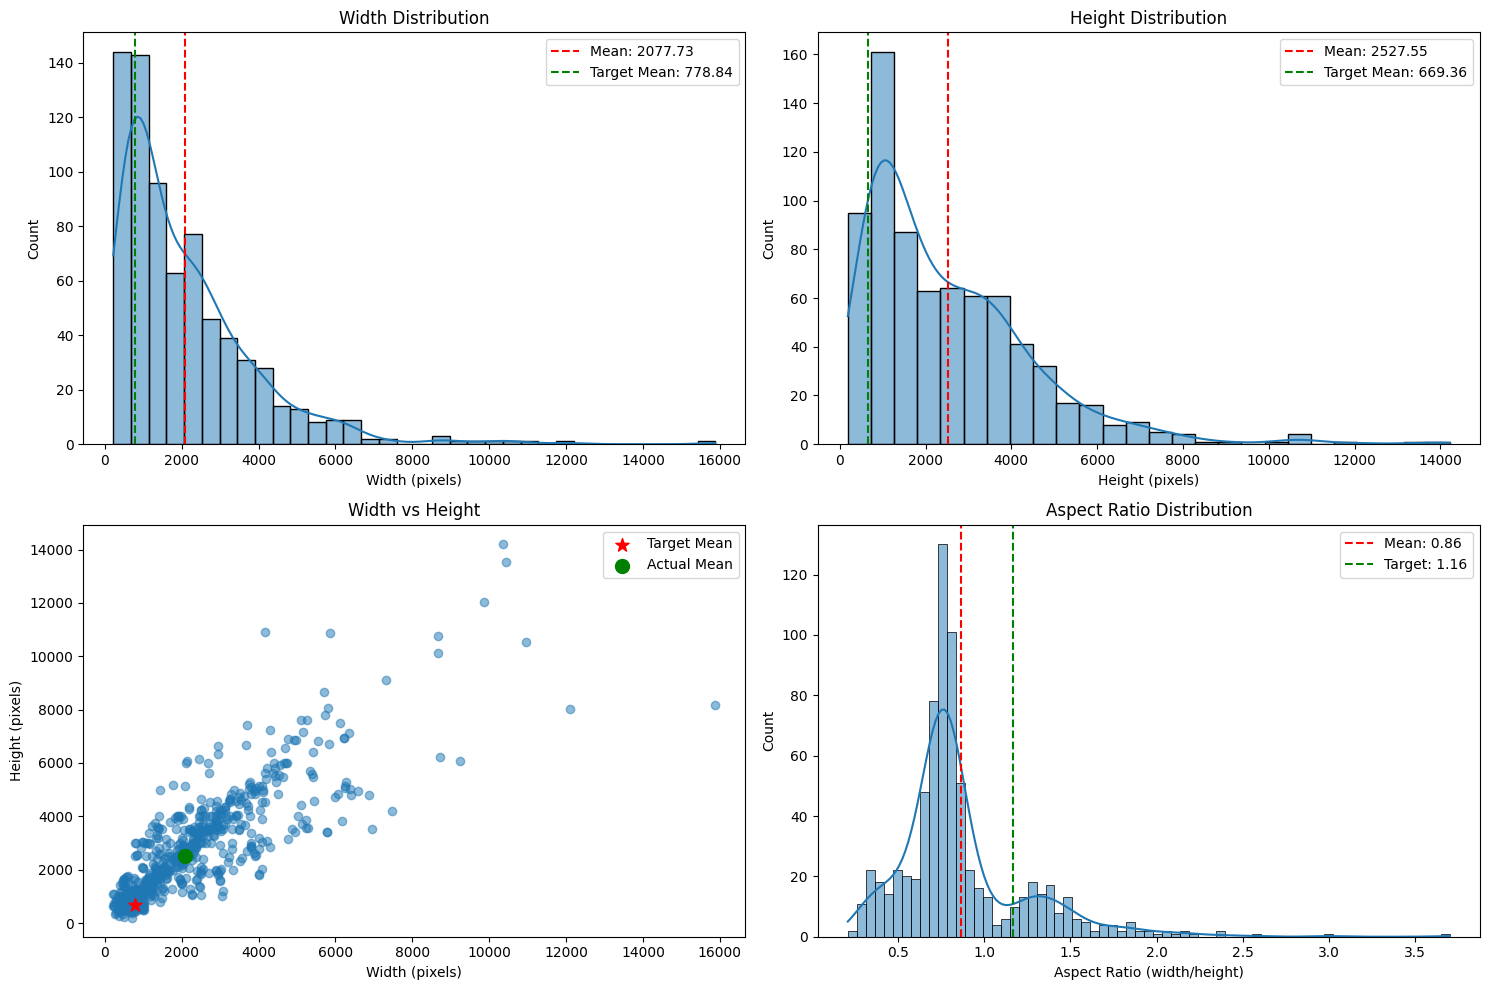

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
plt.figure(figsize=(15, 10))

# Plot width distribution
plt.subplot(2, 2, 1)
sns.histplot(widths, kde=True)
plt.axvline(x=width_mean, color='r', linestyle='--', label=f'Mean: {width_mean:.2f}')
plt.axvline(x=778.84, color='g', linestyle='--', label='Target Mean: 778.84')
plt.title('Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Count')
plt.legend()

# Plot height distribution
plt.subplot(2, 2, 2)
sns.histplot(heights, kde=True)
plt.axvline(x=height_mean, color='r', linestyle='--', label=f'Mean: {height_mean:.2f}')
plt.axvline(x=669.36, color='g', linestyle='--', label='Target Mean: 669.36')
plt.title('Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Count')
plt.legend()

# Plot width vs height scatter
plt.subplot(2, 2, 3)
plt.scatter(widths, heights, alpha=0.5)
plt.scatter(778.84, 669.36, color='r', s=100, marker='*', label='Target Mean')
plt.scatter(width_mean, height_mean, color='g', s=100, marker='o', label='Actual Mean')
plt.title('Width vs Height')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.legend()

# Plot aspect ratio distribution
aspect_ratios = [w/h for w, h in zip(widths, heights)]
plt.subplot(2, 2, 4)
sns.histplot(aspect_ratios, kde=True)
plt.axvline(x=np.mean(aspect_ratios), color='r', linestyle='--', 
            label=f'Mean: {np.mean(aspect_ratios):.2f}')
plt.axvline(x=778.84/669.36, color='g', linestyle='--', 
            label=f'Target: {778.84/669.36:.2f}')
plt.title('Aspect Ratio Distribution')
plt.xlabel('Aspect Ratio (width/height)')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(wikidata_data_dir, 'image_size_distribution.png'))
plt.show()